# TRV: 3. laboratorijska vježba

In [100]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [101]:
SEQUENCE = 9

In [102]:
num_images = os.listdir("../dataset/sequences/{:02d}/image_0".format(SEQUENCE))

#### Funkcije za učitavanje

In [103]:
def read_left_image(frame):
    path = "../dataset/sequences/{:02d}/image_0/{:06d}.png".format(SEQUENCE, frame)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img

def read_right_image(frame):
    path = "../dataset/sequences/{:02d}/image_1/{:06d}.png".format(SEQUENCE, frame)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img

def read_ground_truth():
    name = '../dataset/poses/{:02d}.txt'.format(SEQUENCE)
    poses = pd.read_csv(name, delimiter=' ', header=None)
    poses_np = np.zeros((poses.shape[0], 3, 4))
    for i in range(poses.shape[0]):
        poses_np[i] = np.array(poses.iloc[i]).reshape((3, 4))
    return poses_np

#### Funkcije za projekcijske matrice

In [104]:
def get_p0_and_p1(sequence):
    if sequence < 3:
        p0 = np.array([
            [7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02, 0.000000000000e+00],
            [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02, 0.000000000000e+00],
            [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],
        ])
        p1 = np.array([
            [7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02, -3.861448000000e+02],
            [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02, 0.000000000000e+00],
            [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00]
        ])
    elif sequence == 3:
        p0 = np.array([
            [7.215377000000e+02, 0.000000000000e+00, 6.095593000000e+02, 0.000000000000e+00],
            [0.000000000000e+00, 7.215377000000e+02, 1.728540000000e+02, 0.000000000000e+00],
            [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00]
        ])
    
        p1 = np.array([
            [7.215377000000e+02, 0.000000000000e+00, 6.095593000000e+02, -3.875744000000e+02],
            [0.000000000000e+00, 7.215377000000e+02, 1.728540000000e+02, 0.000000000000e+00],
            [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00]
        ])
    elif sequence > 3:
        p0 = np.array([
            [7.070912000000e+02, 0.000000000000e+00, 6.018873000000e+02, 0.000000000000e+00],
            [0.000000000000e+00, 7.070912000000e+02, 1.831104000000e+02, 0.000000000000e+00],
            [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00]
        ]);
        p1 = np.array([
            [7.070912000000e+02, 0.000000000000e+00, 6.018873000000e+02, -3.798145000000e+02],
            [0.000000000000e+00, 7.070912000000e+02, 1.831104000000e+02, 0.000000000000e+00],
            [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00]
        ])
    return p0, p1

def decompose_projection_matrix(p):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    return k, r, (t/t[3])[:3]

In [105]:
p0, p1 = get_p0_and_p1(SEQUENCE)

#### Funkcije za izračunavanje dubine

In [106]:
def calculate_disparity(img0, img1):  
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11
    matcher = cv2.StereoSGBM_create(
        numDisparities=num_disparities,
        blockSize=block_size,
        P1 = 8 * 3 * block_size ** 2,
        P2 = 32 * 3 * block_size ** 2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
    )
    disparity = matcher.compute(img0, img1).astype(np.float32)/16
    return disparity

def calculate_mask(img0):
    mask = np.zeros(img0.shape[:2], dtype=np.uint8)
    y, x = img0.shape
    cv2.rectangle(mask, (96, 0), (x, y), (255), thickness=-1)
    return mask

def calculate_depth_map(disparity, k0, t0, t1):
    f = k0[0, 0]
    b = t1[0] - t0[0]
    disparity[disparity == 0] = 1e-1
    disparity[disparity == -1] = 1e-1
    depth_map = np.ones(disparity.shape)
    depth_map = f * b / disparity
    return depth_map

def stereo_depth(img0, img1, p0, p1):
    disparity = calculate_disparity(img0, img1)
    k0, _, t0 = decompose_projection_matrix(p0)
    _, _, t1 = decompose_projection_matrix(p1)
    depth = calculate_depth_map(disparity, k0, t0, t1)
    return depth

In [107]:
mask = calculate_mask(read_left_image(0))

#### Funkcije za značajke

In [108]:
def detect_features(img, mask=None):
    sift = cv2.SIFT_create()
    keypts, descriptors = sift.detectAndCompute(img, mask)
    return keypts, descriptors

def match_features(descriptors0, descriptors1, k=2, mask=None):
    bf = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descriptors0, descriptors1, k=k)
    matches = sorted(matches, key=lambda m: m[0].distance)
    return matches

def filter_good_matches(matches, threshold=0.3):
    good_matches = []
    for m, n in matches:
        if m.distance <= threshold * n.distance:
            good_matches.append(m)
    return good_matches

#### Funkcije za pronalaženje transformacije

In [109]:
def find_transform_stereo(matches, keypts0, keypts1, k0, depth, max_depth=3000):
    image0_keypts = np.array([keypts0[m.queryIdx].pt for m in matches])
    image1_keypts = np.array([keypts1[m.trainIdx].pt for m in matches])
    
    cx, cy, fx, fy = k0[0, 2], k0[1, 2], k0[0, 0], k0[1, 1]
    r, t = np.eye(3), np.zeros((3, 1))
    points, delete = [], []
    
    for i, (u, v) in enumerate(image0_keypts):
        z = depth[v.astype(np.int32), u.astype(np.int32)]
        if z > max_depth:
            delete.append(i)
            continue
            
        x = z * (u - cx) / fx
        y = z * (v - cy) / fy
        points.append([x, y, z])
    
    points = np.array(points)
    
    image0_keypts_refined = np.array([kpt for i, kpt in enumerate(image0_keypts) if i not in delete])
    image1_keypts_refined = np.array([kpt for i, kpt in enumerate(image1_keypts) if i not in delete])
    
    _, r, t, _ = cv2.solvePnPRansac(points, image1_keypts_refined, k0, None)
    r = cv2.Rodrigues(r)[0]
    
    return r, t

def find_transform_mono(matches, keypts0, keypts1, k0):
    image0_keypts = np.array([keypts0[m.queryIdx].pt for m in matches])
    image1_keypts = np.array([keypts1[m.trainIdx].pt for m in matches])
    r, t = np.eye(3), np.zeros((3, 1))
    
    E = cv2.findEssentialMat(image0_keypts, image1_keypts, k0)[0]
    _, r, t, _ = cv2.recoverPose(E, image0_keypts, image1_keypts, k0)
    return r, t

#### Funkcije za iscrtavanje

In [110]:
%matplotlib notebook

def setup_figure(figsize=(8, 8), azim=270, elev=-20):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=elev, azim=azim)
    return fig, ax

def plot_ground_truth(poses, ax):
    xs = poses[:, 0, 3]
    ys = poses[:, 1, 3]
    zs = poses[:, 2, 3]
    ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
    ax.plot(xs, ys, zs, c='k')

def add_point_to_plot(path, i):
    xs = path[:i+2, 0, 3]
    ys = path[:i+2, 1, 3]
    zs = path[:i+2, 2, 3]
    plt.plot(xs, ys, zs, c='chartreuse')

#### Stereo vizualna odometrija

In [111]:
def visual_odometry(p0, type_='stereo', mask=None, threshold=0.3):
    
    ground_truth = read_ground_truth()
    
    fig, ax = setup_figure()
    plot_ground_truth(ground_truth, ax)
    
    pose = np.eye(4)
    path = np.zeros((len(num_images), 3, 4))

    k0, _, _ = decompose_projection_matrix(p0)
    
    for i in tqdm(range(len(num_images)-1)):

        if i == 0:
            image_left_prev = read_left_image(i)
            image_right_prev = read_right_image(i)
            continue

        image_left_curr = read_left_image(i)
        
        keypts_left_prev, descriptors_left_prev = detect_features(image_left_prev, mask)
        keypts_left_curr, descriptors_left_curr = detect_features(image_left_curr, mask)
        
        matches = match_features(descriptors_left_prev, descriptors_left_curr)
        matches = filter_good_matches(matches, threshold)
        
        if type_ == 'stereo':
            depth = stereo_depth(image_left_prev, image_right_prev, p0, p1)
            r, t = find_transform_stereo(matches, keypts_left_prev, keypts_left_curr, k0, depth)
        elif type_ == 'mono':
            r, t = find_transform_mono(matches, keypts_left_prev, keypts_left_curr, k0)
            
        transform = np.vstack((np.hstack((r, t)), [0, 0, 0, 1]))
            
        pose = pose.dot(np.linalg.inv(transform))
        path[i+1] = pose[:3]
        
        add_point_to_plot(path, i)
            
        image_left_prev = image_left_curr
        image_right_prev = read_right_image(i)
        
    return path, ground_truth

<IPython.core.display.Javascript object>


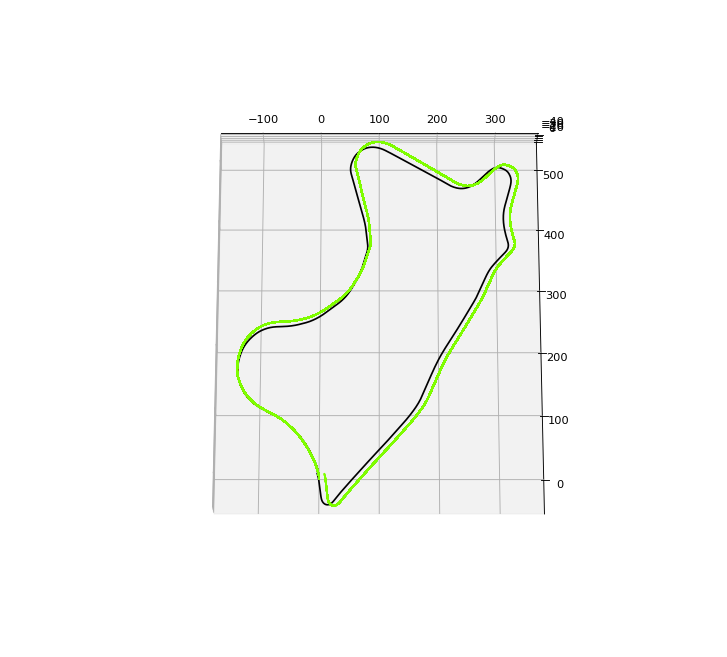

100%|██████████████████████████████████████████████████████████████████████████████| 1590/1590 [05:17<00:00,  5.01it/s]


In [112]:
path, ground_truth = visual_odometry(p0)

In [113]:
def save_kitti_pose(path):
    name = '../dataset/results/{:02d}.txt'.format(SEQUENCE)
    df = pd.DataFrame(path.reshape(-1, 12))
    df.to_csv(name, sep=' ', header=None, index=False)
    
save_kitti_pose(path)

In [114]:
!evo_ape kitti ../dataset/poses/09.txt ../dataset/results/09.txt -va --plot --plot_mode xz --save_results ../dataset/results/stereo_ape.zip

--------------------------------------------------------------------------------
Loaded 1591 poses from: ../dataset/poses/09.txt
Loaded 1591 poses from: ../dataset/results/09.txt
--------------------------------------------------------------------------------
Aligning using Umeyama's method...
Rotation of alignment:
[[ 0.99971147 -0.0227586  -0.00768222]
 [ 0.0229193   0.99950563  0.02152223]
 [ 0.0071886  -0.0216921   0.99973885]]
Translation of alignment:
[-5.54704853 -0.30513729 -2.44178326]
Scale correction: 1.0
--------------------------------------------------------------------------------
Compared 1591 absolute pose pairs.
Calculating APE for translation part pose relation...
--------------------------------------------------------------------------------
APE w.r.t. translation part (m)
(with SE(3) Umeyama alignment)

       max	8.095625
      mean	4.792399
    median	5.061988
       min	0.647523
      rmse	5.186222
       sse	42792.970653
       std	1.982376

------------------

In [118]:
!evo_rpe kitti ../dataset/poses/09.txt ../dataset/results/09.txt -va --plot --plot_mode xz --save_results ../dataset/results/stereo_rpe.zip

--------------------------------------------------------------------------------
Loaded 1591 poses from: ../dataset/poses/09.txt
Loaded 1591 poses from: ../dataset/results/09.txt
--------------------------------------------------------------------------------
Aligning using Umeyama's method...
Rotation of alignment:
[[ 0.99971147 -0.0227586  -0.00768222]
 [ 0.0229193   0.99950563  0.02152223]
 [ 0.0071886  -0.0216921   0.99973885]]
Translation of alignment:
[-5.54704853 -0.30513729 -2.44178326]
Scale correction: 1.0
--------------------------------------------------------------------------------
Found 1590 pairs with delta 1 (frames) among 1591 poses using consecutive pairs.
Compared 1590 relative pose pairs, delta = 1 (frames) with consecutive pairs.
Calculating RPE for translation part pose relation...
--------------------------------------------------------------------------------
RPE w.r.t. translation part (m)
for delta = 1 (frames) using consecutive pairs
(with SE(3) Umeyama alig

#### Monokularna vizualna odometrija

<IPython.core.display.Javascript object>


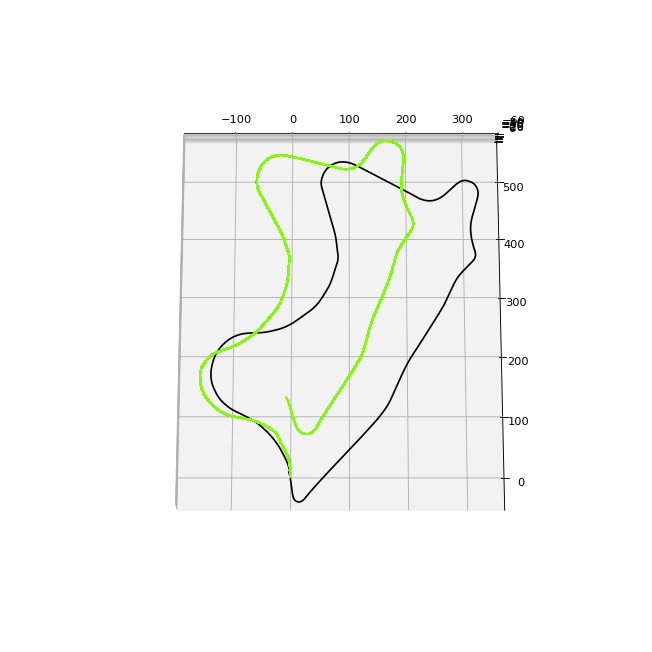

100%|██████████████████████████████████████████████████████████████████████████████| 1590/1590 [04:07<00:00,  6.42it/s]


In [119]:
path_mono, ground_truth_mono = visual_odometry(p0, type_='mono')

In [121]:
save_kitti_pose(path_mono)

In [128]:
!evo_ape kitti ../dataset/poses/09.txt ../dataset/results/09.txt -va --plot --plot_mode xz --save_results ../dataset/results/mono_ape.zip

^C


In [127]:
!evo_rpe kitti ../dataset/poses/09.txt ../dataset/results/09.txt -va --plot --plot_mode xz --save_results ../dataset/results/mono_rpe.zip

--------------------------------------------------------------------------------
Loaded 1591 poses from: ../dataset/poses/09.txt
Loaded 1591 poses from: ../dataset/results/09.txt
--------------------------------------------------------------------------------
Aligning using Umeyama's method...
Rotation of alignment:
[[ 0.96253881 -0.10800117  0.24870622]
 [ 0.09413072  0.99330012  0.06703933]
 [-0.25428025 -0.04111706  0.96625615]]
Translation of alignment:
[ -9.08902596   2.06178941 -12.81651951]
Scale correction: 1.0
--------------------------------------------------------------------------------
Found 1590 pairs with delta 1 (frames) among 1591 poses using consecutive pairs.
Compared 1590 relative pose pairs, delta = 1 (frames) with consecutive pairs.
Calculating RPE for translation part pose relation...
--------------------------------------------------------------------------------
RPE w.r.t. translation part (m)
for delta = 1 (frames) using consecutive pairs
(with SE(3) Umeyama a